# Challenge: Model Comparison
You now know two kinds of regression and two kinds of classifier. So let's use that to compare models!

Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('~/thinkful_mac/thinkful_large_files/Melbourne_housing_extra_data.csv')

In [4]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude
0,Abbotsford,68 Studley St,2.0,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra,-37.8014,144.9958
1,Abbotsford,85 Turner St,2.0,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984
2,Abbotsford,25 Bloomburg St,2.0,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934
3,Abbotsford,18/659 Victoria St,3.0,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra,-37.8114,145.0116
4,Abbotsford,5 Charles St,3.0,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944


# Clean the data by removing NaNs and zeros. For this exercise, we will not impute missing values.

In [5]:
#Drop obs where we don't know the price - we clearly can't build our model with missing values
df.dropna(subset = ['Price'], inplace = True)

#Drop address (doesn't make sense to include in model) and postcode (model will try to use it as a continuous variable)
#Lat & Long also contain most of the info as Postalcode anyway. 

#Replace 0's in Landsize with NaN (drop?), and same with BuildingArea
df['Landsize'].replace(0, np.nan, inplace = True)
df['BuildingArea'].replace(0, np.nan, inplace = True)


print(len(df))

9421


In [7]:
#Is there any way around dropping NaNs?
df.dropna(subset = ['Landsize', 'BuildingArea', 'Lattitude', 'Longtitude', 'Bedroom2', 'Bathroom', 'Car', 'Rooms'], inplace = True)
print(len(df))

3366


# Let's get a quick sense of what our data looks like

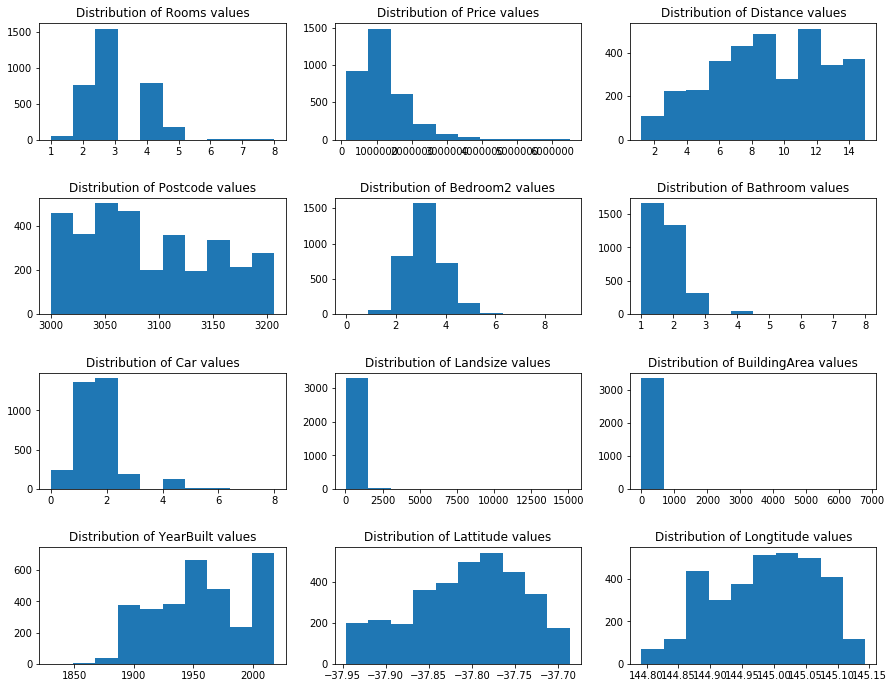

In [10]:
numeric_cols = df.select_dtypes(include = np.number).columns.tolist()
#Create an x by 3 array of subplots (x = number of rows, will depend on number of plots needed)
x = np.ceil((len(numeric_cols) + 1)/3)

#Set figure size prior to creating subplots
plt.figure(figsize = (15,15))
plt.subplots_adjust(hspace=0.5)
#Plot subplots
for i in range(0,len(numeric_cols)):
    plt.subplot(x, 3, i+1)
    plt.hist(df[numeric_cols[i]].dropna())
    plt.title('Distribution of {} values'.format(numeric_cols[i]))

In [11]:
#Linear Model: select subset of vars which seem like they would contribute to explanatory power of model

df2 = pd.DataFrame()
df2['Suburb'] = df['Suburb']
df2['Type'] = df['Type']
df2['Bedrooms'] = df['Bedroom2']
df2['Bathrooms'] = df['Bathroom']
df2['Distance'] = df['Distance']
df2['Latitude'] = df['Lattitude']
df2['Longitude'] = df['Longtitude']
df2['Landsize'] = df['Landsize']
df2['BuildingArea'] = df['BuildingArea']
df2['Car'] = df['Car']
df2['Price'] = df['Price']

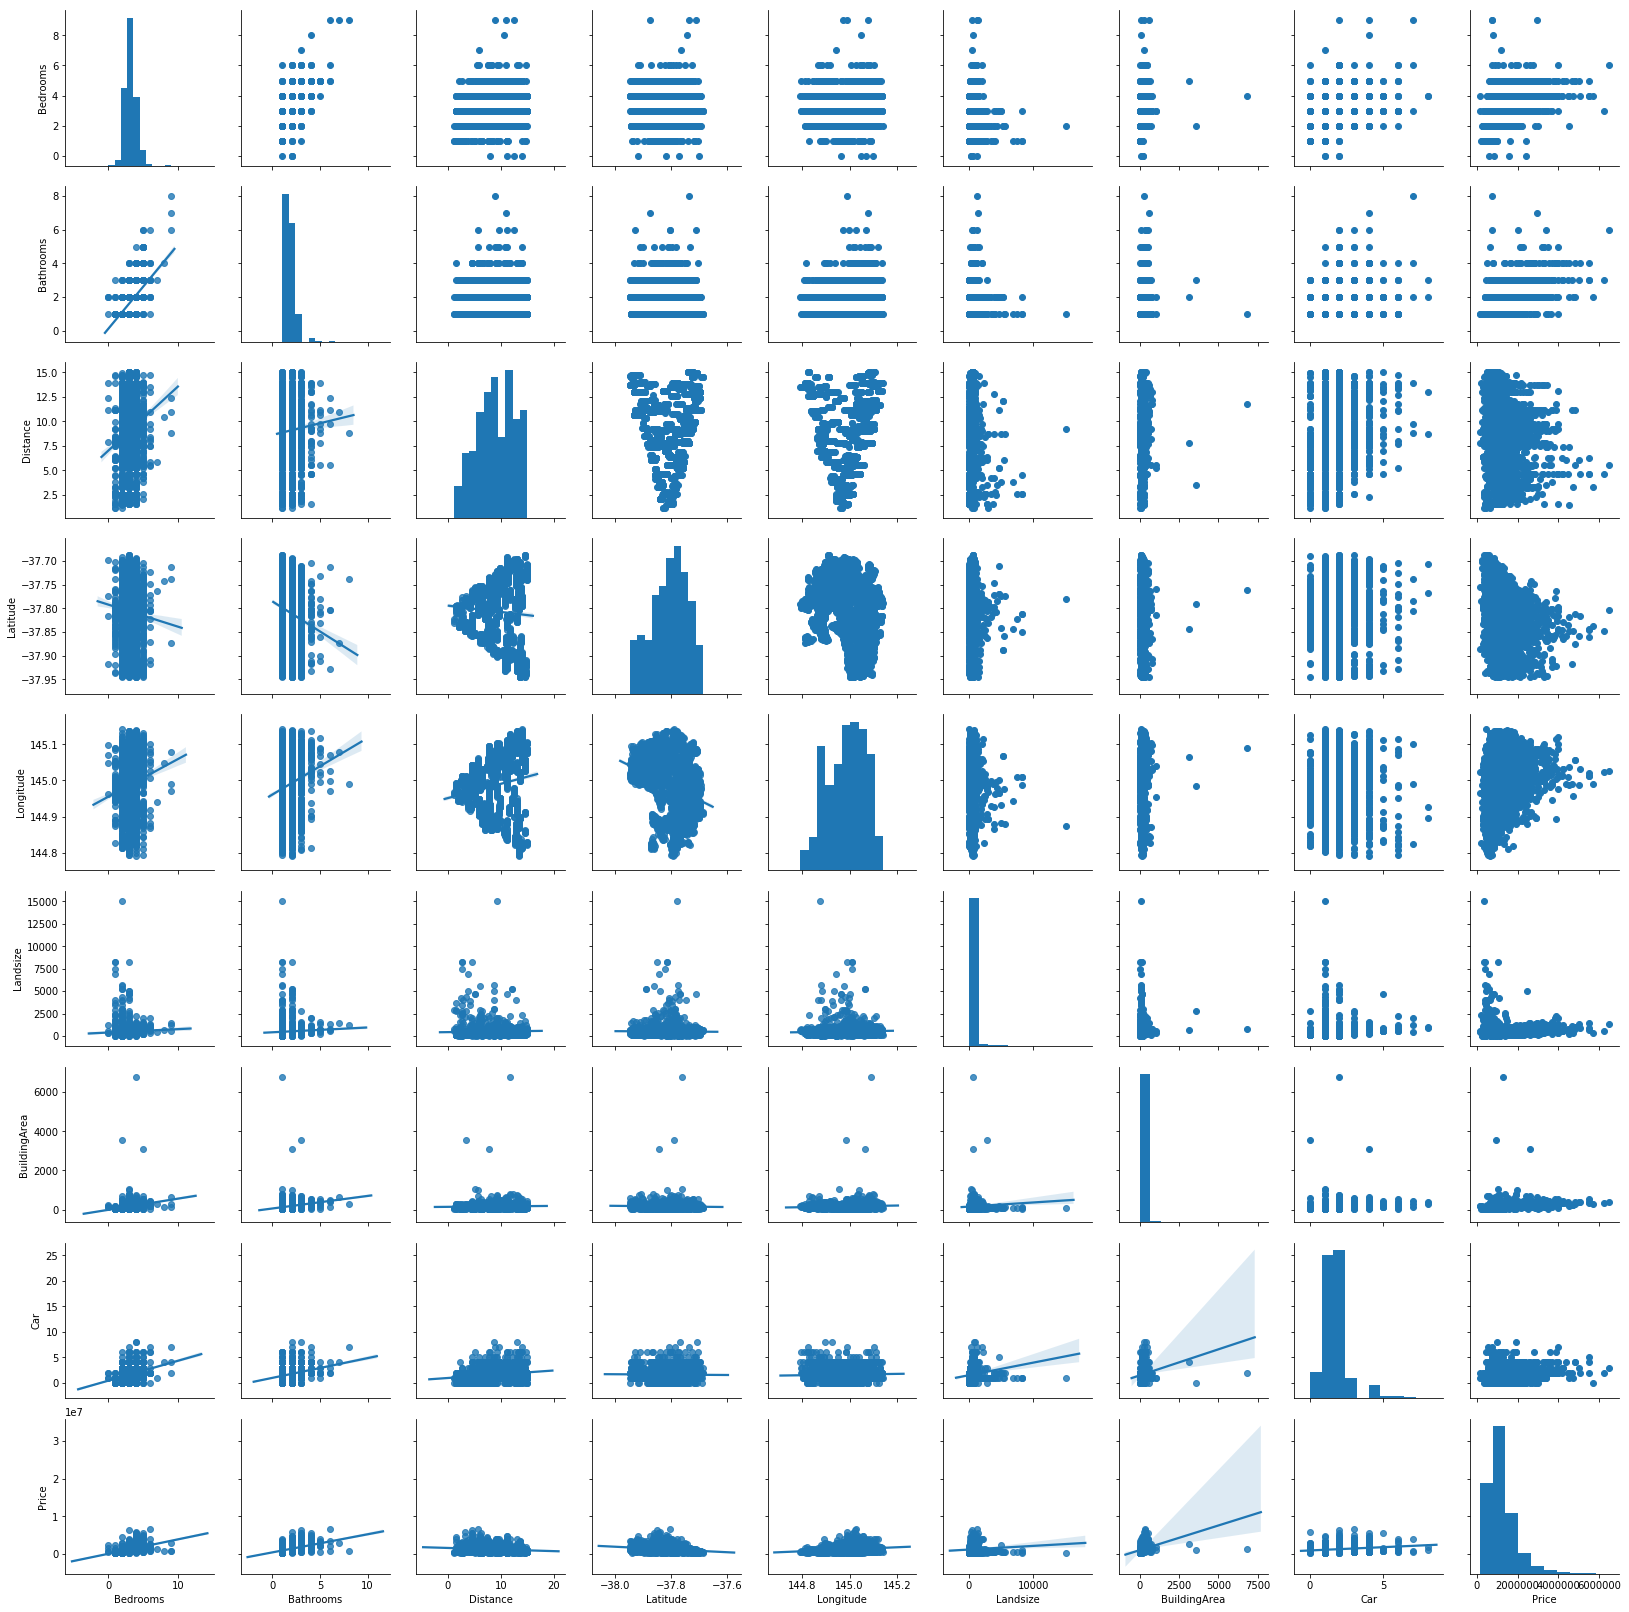

In [15]:
g = sns.PairGrid(df2, diag_sharey=False)
g.map_upper(plt.scatter)
g.map_lower(sns.regplot)
g.map_diag(plt.hist)
plt.show()

In [26]:
#Fit the linear model on data as-is

from scipy.stats import f
import statsmodels.formula.api as smf


# Write out the model formula.
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Price ~ Suburb + Type + Bedrooms + Bathrooms + Latitude + Longitude + Landsize + BuildingArea + Car' 
#+ Distance + Longitude' 
# Longitude dropped because longitude's variance is captured by Suburb (pval < 0.05)
# Distance dropped because pval < 0.05.

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df2).fit()

In [29]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     52.54
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        23:07:39   Log-Likelihood:                -48037.
No. Observations:                3366   AIC:                         9.637e+04
Df Residuals:                    3218   BIC:                         9.728e+04
Df Model:                         147                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     5.029e+07   1.24e+08      0.405      0.686   -1.93e+08    2.94e+08
Suburb[T.Aberfeldie]          8.106e+04   1.63e+05      0.498      0.619   -2.38e+05       4e+05
Suburb[T.Airport West]       -3.664e+05   1.75e+05     -2.095      0.036   -7.09e+05   -2.34e+04
Suburb[T.Albert Park]         5.952e+05   1.34e+05      4.445      0.000    3.33e+05    8.58e+05
Suburb[T.Albion]             -7.341e+05   2.05e+05     -3.579      0.000   -1.14e+06   -3.32e+05
Suburb[T.Alphington]          2.749e+05   1.56e+05      1.764      0.078   -3.07e+04     5.8e+05
Suburb[T.Altona]              -7.96e+05   2.07e+05     -3.844      0.000    -1.2e+06    -3.9e+05
Suburb[T.Altona North]         -9.6e+05   1.81e+05     -5.300      0.000   -1.32e+06   -6.05e+05
Suburb[T.Armadale]            6.136e+05   1.37e+05      4.474      0.000    3.45e+05    8.83e+05
Suburb[T.Ascot Vale]          -2.31e+05   1.22e+05     -1.888      0.059   -4.71e+05    8897.467
Suburb[T.Ashburton]          -1665.9946   1.48e+05     -0.011      0.991   -2.91e+05    2.88e+05
Suburb[T.Ashwood]            -2.853e+05   1.63e+05     -1.750      0.080   -6.05e+05    3.43e+04
Suburb[T.Avondale Heights]   -6.584e+05   1.74e+05     -3.774      0.000      -1e+06   -3.16e+05
Suburb[T.Balaclava]          -1.264e+05   1.96e+05     -0.643      0.520   -5.12e+05    2.59e+05
Suburb[T.Balwyn]              5.523e+05   1.24e+05      4.448      0.000    3.09e+05    7.96e+05
Suburb[T.Balwyn North]        4.369e+05   1.25e+05      3.489      0.000    1.91e+05    6.82e+05
Suburb[T.Bellfield]          -4.051e+05   2.26e+05     -1.796      0.073   -8.47e+05    3.72e+04
Suburb[T.Bentleigh]          -4.284e+05   1.78e+05     -2.410      0.016   -7.77e+05   -7.98e+04
Suburb[T.Bentleigh East]     -6.042e+05   1.75e+05     -3.461      0.001   -9.46e+05   -2.62e+05
Suburb[T.Box Hill]            1.336e+05   1.59e+05      0.841      0.400   -1.78e+05    4.45e+05
Suburb[T.Braybrook]          -7.743e+05   1.71e+05     -4.534      0.000   -1.11e+06   -4.39e+05
Suburb[T.Brighton]            3.342e+05   1.64e+05      2.033      0.042    1.19e+04    6.57e+05
Suburb[T.Brighton East]       -2.67e+05    1.7e+05     -1.570      0.116      -6e+05    6.64e+04
Suburb[T.Brooklyn]           -8.941e+05   4.21e+05     -2.125      0.034   -1.72e+06    -6.9e+04
Suburb[T.Brunswick]          -3.886e+04   1.07e+05     -0.362      0.718    -2.5e+05    1.72e+05
Suburb[T.Brunswick East]      2.596e+04   1.29e+05      0.202      0.840   -2.26e+05    2.78e+05
Suburb[T.Brunswick West]     -2.299e+05    1.3e+05     -1.773      0.076   -4.84e+05    2.44e+04
Suburb[T.Bulleen]            -2.481e+05   1.52e+05     -1.633      0.103   -5.46e+05    4.99e+04
Suburb[T.Burnley]             7330.1203   2.14e+05      0.034      0.973   -

Not all of the suburb indicators are significant - future versions of this model can experiment with dropping non-significant columns.

In [91]:
#Above parameter p-values suggest we can drop distance from the model (p > 0.05) -- dropped.

#Longitude does not provide any information on top of suburb, but does contribute information if suburb is dropped.

#Want to keep suburb because it drastically improves the R^2, so we can drop longitude in that case (.576 vs .706)

#Convert 'Suburb' and 'Type' from categorical to numerical variables for this model using dummy variables


#Create dummy variables
suburb_dummies = pd.get_dummies(df2.Suburb, prefix='suburb')
type_dummies = pd.get_dummies(df2.Type, prefix='type')

#Drop the first column (In general, if you have a categorical feature with k possible values, you create k-1 dummy variables.)
suburb_dummies.drop(suburb_dummies.columns[0], axis=1, inplace=True)
type_dummies.drop(type_dummies.columns[0], axis=1, inplace=True)

#Add the dummy columns to our current dataframe (df2)
#Concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
df3 = pd.concat([df2[['Bedrooms','Bathrooms','Latitude','Landsize','BuildingArea',
                      'Car']], suburb_dummies, type_dummies], axis=1)

df3.head()

,Bedrooms,Bathrooms,Latitude,Landsize,BuildingArea,Car,suburb_Aberfeldie,suburb_Airport West,suburb_Albert Park,suburb_Albion,...,suburb_Watsonia,suburb_West Footscray,suburb_West Melbourne,suburb_Williamstown,suburb_Williamstown North,suburb_Windsor,suburb_Yallambie,suburb_Yarraville,type_t,type_u
2,2.0,1.0,-37.8079,156.0,79.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,2.0,-37.8093,134.0,150.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3.0,1.0,-37.8072,120.0,142.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,4.0,2.0,-37.8024,245.0,210.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,2.0,1.0,-37.8060,256.0,107.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Evaluate initial performance

In [92]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = df3
Y = df2['Price']

regr.fit(X,Y)

# Inspect the results.
#print('\nCoefficients: \n', regr.coef_)
#print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


R-squared:
0.7056701695694102


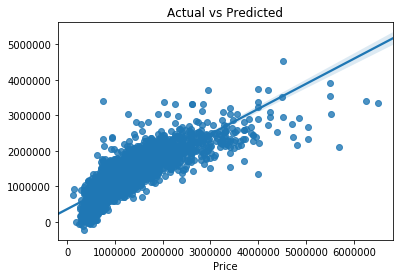

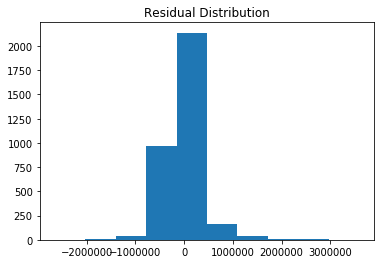

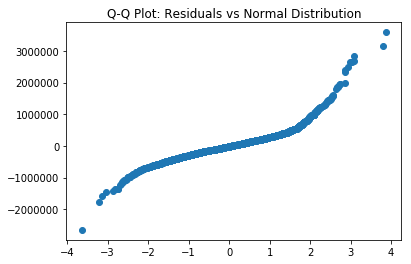

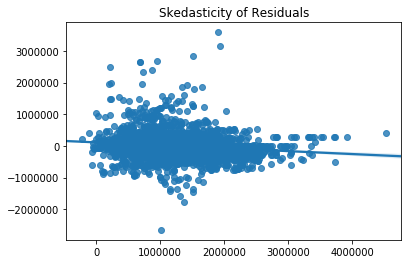

In [93]:
actual = df2['Price']
predicted = regr.predict(X).ravel()
residual = actual - predicted

#Evaluate performance of regression model 
sns.regplot(actual, predicted)
plt.title('Actual vs Predicted')
plt.show()

plt.hist(residual)
plt.title('Residual Distribution')
plt.show()

norm = np.random.normal(0,1,len(residual))
norm.sort()

residual = np.array(residual)
residual.sort()

plt.scatter(norm, residual)
plt.title('Q-Q Plot: Residuals vs Normal Distribution')
plt.show()


sns.regplot(predicted, residual)
plt.title('Skedasticity of Residuals')
plt.show()

Residuals are not normal and there is heteroskedasticity as well.

# Transform the target variable

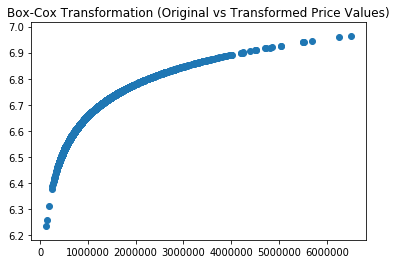

In [96]:
#The linear regression model we built here is not great...

#Hence I will attempt to improve this with a box-cox transformation

from scipy.stats import boxcox
from scipy.stats import boxcox_normmax

#regular box-cox was erroring out (stated that zeros were included, but they are not) - see discussison here: https://github.com/scipy/scipy/issues/6873
lambda_max = boxcox_normmax(df2['Price'], brack=(-1.99, 1.99),  method='mle')
bc = boxcox(df2['Price'], lambda_max)

plt.scatter(df2['Price'], bc)
plt.title('Box-Cox Transformation (Original vs Transformed Price Values)')
plt.show()

df3['Price_BC_Transform'] = bc

In [99]:
#Transform the predictors to try to create a linear relationship with the (transformed) target var
df4 = df3.copy()

#Some homes had 0 bedrooms, so add 1 to all datapoints, and see what the log transform looks like
df4['Bedrooms_Plus_1'] = df4['Bedrooms'] + 1
df4['Bedrooms_Plus_1_Log'] = np.log(df4['Bedrooms_Plus_1'])
df4['Bedrooms_Sqrt'] = np.sqrt(df4['Bedrooms'])

df4['Bathrooms_Log'] = np.log(df4['Bathrooms'])
df4['Bathrooms_Sqrt'] = np.sqrt(df4['Bathrooms'])

df4['Landsize_Log'] = np.log(df4['Landsize'])
df4['Landsize_Sqrt'] = np.sqrt(df4['Landsize'])

df4['BuildingArea_Log'] = np.log(df4['BuildingArea'])
df4['BuildingArea_Sqrt'] = np.sqrt(df4['BuildingArea'])

df4['Car_Plus_1'] = df4['Car'] + 1
df4['Car_Plus_1_Log'] = np.log(df4['Car_Plus_1'])
df4['Car_Sqrt'] = np.sqrt(df4['Car'])

#Take abs value of latitude so log is a real number
df4['Latitude_Log'] = np.log(abs(df4['Latitude']))
df4['Latitude_Sqrt'] = np.sqrt(abs(df4['Latitude']))


#Add suburb & type back to df4 to build the new linear model & select relevant params

df4['Suburb'] = df2['Suburb']
df4['Type'] = df2['Type']

In [100]:
#Create new linear model and only keep relevant parameters...

#Suburb & dummy variables will be included 

linear_formula = 'Price_BC_Transform ~ Suburb + Type + Bedrooms_Plus_1_Log + Bedrooms_Sqrt + Bathrooms_Log + Bathrooms_Sqrt + Landsize_Log + Landsize_Sqrt + BuildingArea_Log + BuildingArea_Sqrt + Car_Plus_1_Log + Car_Sqrt + Latitude_Log + Latitude_Sqrt'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df4).fit()

In [102]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Price_BC_Transform   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     104.6
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        00:30:38   Log-Likelihood:                 6194.3
No. Observations:                3366   AIC:                        -1.208e+04
Df Residuals:                    3213   BIC:                        -1.115e+04
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -4.253e+04   7928.151     -5.364      0.000   -5.81e+04    -2.7e+04
Suburb[T.Aberfeldie]             0.0030      0.015      0.207      0.836      -0.026       0.032
Suburb[T.Airport West]          -0.0363      0.016     -2.213      0.027      -0.069      -0.004
Suburb[T.Albert Park]            0.0572      0.013      4.433      0.000       0.032       0.082
Suburb[T.Albion]                -0.1356      0.015     -9.139      0.000      -0.165      -0.106
Suburb[T.Alphington]             0.0040      0.015      0.258      0.796      -0.026       0.034
Suburb[T.Altona]                -0.0993      0.014     -6.933      0.000      -0.127      -0.071
Suburb[T.Altona North]          -0.1532      0.013    -11.625      0.000      -0.179      -0.127
Suburb[T.Armadale]               0.0269      0.014      1.926      0.054      -0.000       0.054
Suburb[T.Ascot Vale]            -0.0380      0.011     -3.587      0.000      -0.059      -0.017
Suburb[T.Ashburton]             -0.0286      0.014     -2.024      0.043      -0.056      -0.001
Suburb[T.Ashwood]               -0.0700      0.015     -4.785      0.000      -0.099      -0.041
Suburb[T.Avondale Heights]      -0.1022      0.014     -7.259      0.000      -0.130      -0.075
Suburb[T.Balaclava]             -0.0228      0.020     -1.137      0.256      -0.062       0.017
Suburb[T.Balwyn]                 0.0114      0.010      1.099      0.272      -0.009       0.032
Suburb[T.Balwyn North]           0.0036      0.010      0.362      0.718      -0.016       0.023
Suburb[T.Bellfield]             -0.1043      0.022     -4.637      0.000      -0.148      -0.060
Suburb[T.Bentleigh]             -0.0346      0.021     -1.617      0.106      -0.076       0.007
Suburb[T.Bentleigh East]        -0.0659      0.020     -3.231      0.001      -0.106      -0.026
Suburb[T.Box Hill]              -0.0380      0.012     -3.174      0.002      -0.061      -0.015
Suburb[T.Braybrook]             -0.1367      0.013    -10.773      0.000      -0.162      -0.112
Suburb[T.Brighton]               0.0322      0.019      1.681      0.093      -0.005       0.070
Suburb[T.Brighton East]         -0.0144      0.020     -0.714      0.475      -0.054       0.025
Suburb[T.Brooklyn]              -0.1627      0.040     -4.042      0.000      -0.242      -0.084
Suburb[T.Brunswick]             -0.0112      0.011     -1.045      0.296      -0.032       0.010
Suburb[T.Brunswick East]        -0.0082      0.013     -0.632      0.528      -0.034       0.017
Suburb[T.Brunswick West]        -0.0437      0.013     -3.460      0.001      -0.068      -0.019
Suburb[T.Bulleen]               -0.0667      0.013     -5.226      0.000      -0.092      -0.042
Suburb[T.Burnley]               -0.0074      0.022     -0.346      0.729    

# More visual inspection of linear relationships

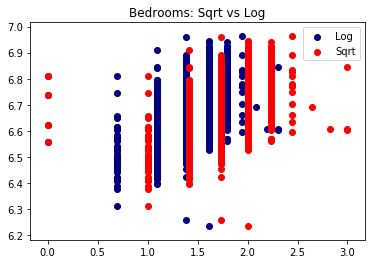

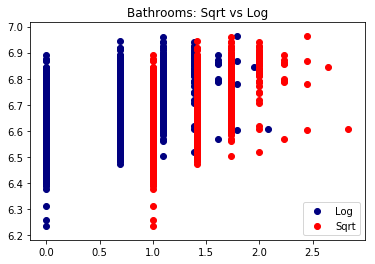

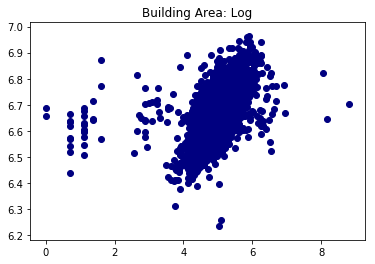

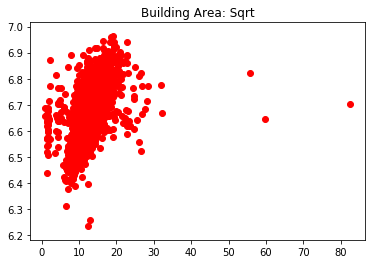

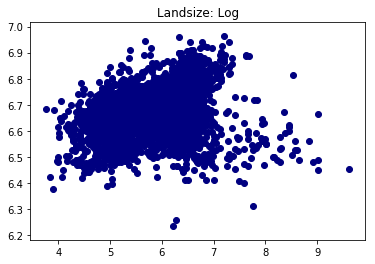

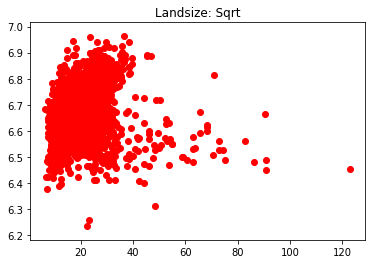

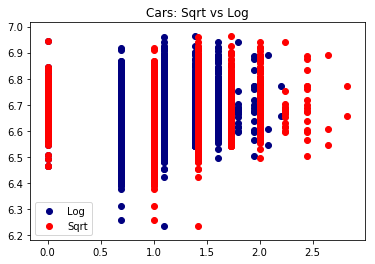

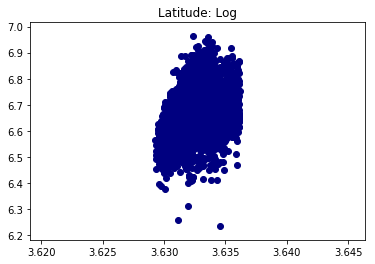

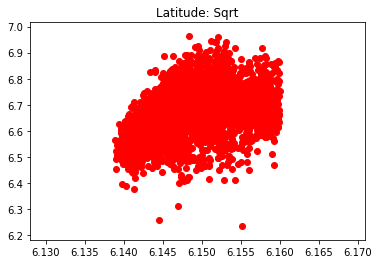

In [132]:
# How do these engineered features map to our transformed output (are they linear?)

plt.scatter(df4.Bedrooms_Plus_1_Log, df4.Price_BC_Transform, c='Navy', label='Log')
plt.scatter(df4.Bedrooms_Sqrt, df4.Price_BC_Transform, c='Red', label='Sqrt')
plt.legend()
plt.title('Bedrooms: Sqrt vs Log')
plt.show()

plt.scatter(df4.Bathrooms_Log, df4.Price_BC_Transform, c='Navy', label='Log')
plt.scatter(df4.Bathrooms_Sqrt, df4.Price_BC_Transform, c='Red', label='Sqrt')
plt.legend()
plt.title('Bathrooms: Sqrt vs Log')
plt.show()

plt.scatter(df4.BuildingArea_Log, df4.Price_BC_Transform, c='Navy', label='Log')
plt.title('Building Area: Log')
plt.show()

plt.scatter(df4.BuildingArea_Sqrt, df4.Price_BC_Transform, c='Red', label='Sqrt')
plt.title('Building Area: Sqrt')
plt.show()

plt.scatter(df4.Landsize_Log, df4.Price_BC_Transform, c='Navy', label='Log')
plt.title('Landsize: Log')
plt.show()

plt.scatter(df4.Landsize_Sqrt, df4.Price_BC_Transform, c='Red', label='Sqrt')
plt.title('Landsize: Sqrt')
plt.show()

plt.scatter(df4.Car_Plus_1_Log, df4.Price_BC_Transform, c='Navy', label='Log')
plt.scatter(df4.Car_Sqrt, df4.Price_BC_Transform, c='Red', label='Sqrt')
plt.legend()
plt.title('Cars: Sqrt vs Log')
plt.show()

plt.scatter(df4.Latitude_Log, df4.Price_BC_Transform, c='Navy', label='Log')
plt.title('Latitude: Log')
plt.show()

plt.scatter(df4.Latitude_Sqrt, df4.Price_BC_Transform, c='Red', label='Sqrt')
plt.title('Latitude: Sqrt')
plt.show()


It's not extremely obvious which 

In [29]:
#Lets stick with the log values for our model
#Drop Suburb & Type, along with Sqrt fields from df4 & re-run...

df4.drop(['Suburb', 'Type', 'Bedrooms_Sqrt', 'Bathrooms_Sqrt', 'Landsize_Sqrt', 'Latitude_Sqrt', 'BuildingArea_Sqrt', 'Car_Sqrt', 'Bedrooms_Plus_1', 'Car_Plus_1'], axis = 1, inplace = True)

#Move the transformed price to a new df and drop it from df4 before we build the new model (otherwise r2 = 1... and model is fake)

df5 = pd.DataFrame(df4['Price_BC_Transform'])

df4.drop(['Price_BC_Transform'], axis = 1, inplace = True)

In [30]:
df4.drop(['Bedrooms', 'Bathrooms', 'Latitude', 'Landsize', 'BuildingArea', 'Car'], axis = 1, inplace = True)

In [31]:
df4.head()

,suburb_Aberfeldie,suburb_Airport West,suburb_Albert Park,suburb_Albion,suburb_Alphington,suburb_Altona,suburb_Altona North,suburb_Armadale,suburb_Ascot Vale,suburb_Ashburton,...,suburb_Yallambie,suburb_Yarraville,type_t,type_u,Bedrooms_Plus_1_Log,Bathrooms_Log,Landsize_Log,BuildingArea_Log,Car_Plus_1_Log,Latitude_Log
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.098612,0.000000,5.049856,4.369448,0.000000,3.632518
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.386294,0.693147,4.897840,5.010635,0.000000,3.632555
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.386294,0.000000,4.787492,4.955827,1.098612,3.632500
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.609438,0.693147,5.501258,5.347108,0.000000,3.632373
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.098612,0.000000,5.545177,4.672829,1.098612,3.632468


In [42]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = df4
Y = df5['Price_BC_Transform']

#X = df3[['Suburb', 'Type_Num', 'Bedrooms', 'Bathrooms', 'Distance',  'Latitude', 'Landsize', 'BuildingArea', 'Car']]
#Y = df3['Price']

regr.fit(X,Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [  4.85336943e-03  -6.49602436e-02   5.03686859e-02  -1.31204852e-01
   3.17873580e-03  -1.04806765e-01  -1.48533377e-01   2.41649337e-02
  -3.77188032e-02  -3.61726056e-02  -7.52728822e-02  -1.03216107e-01
  -3.33300418e-02   1.96245153e-02   9.84667261e-03  -1.09209135e-01
  -8.40097737e-02  -1.11877168e-01  -2.79389571e-02  -1.33923682e-01
  -5.39123319e-03  -6.01862080e-02  -1.63364060e-01  -1.74631449e-02
  -8.81753123e-03  -4.94353592e-02  -5.99959725e-02  -8.61926308e-03
  -6.54817704e-02   4.29225728e-03   2.35141234e-02   5.15938895e-03
   6.59872026e-02  -7.29866961e-02  -3.24295383e-01  -1.07483819e-01
  -6.85846071e-02  -6.61355912e-02  -9.75370274e-02   5.31514350e-03
  -4.93377419e-02  -7.04919709e-02  -2.80045713e-02  -1.79299229e-02
  -3.40059412e-02   1.58619402e-02   1.86892662e-01  -4.32010824e-02
  -3.50419629e-02  -8.98427895e-03  -2.94194039e-02  -5.10766737e-02
  -3.92394220e-03  -1.11272702e-01   1.74076866e-02   1.18043460e-02
  -2.35210321e-02

In [33]:
actual = df5['Price_BC_Transform']
predicted = regr.predict(X).ravel()
residual = actual - predicted

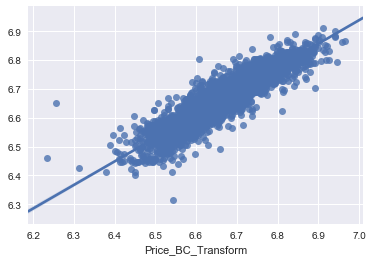

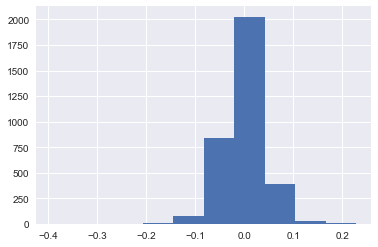

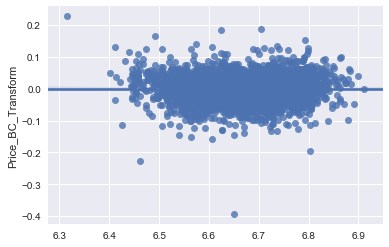

In [34]:
sns.regplot(actual, predicted)
plt.show()

plt.hist(residual)
plt.show()

sns.regplot(predicted, residual)
plt.show()

Plot of Actual vs. Predicted Sales Prices (Transformed): Fold 1


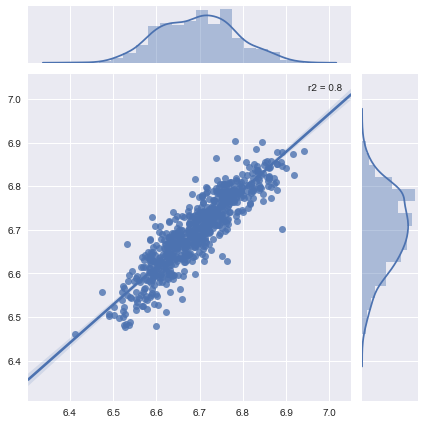

Plot of Actual vs. Predicted Sales Prices (Transformed): Fold 2


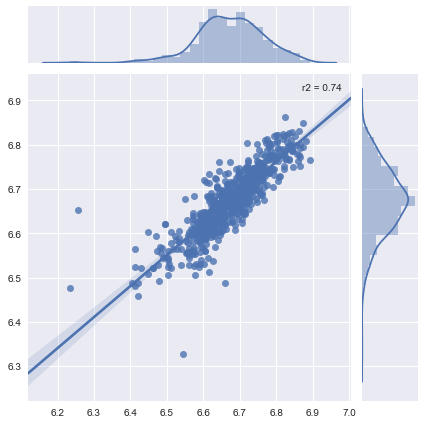

Plot of Actual vs. Predicted Sales Prices (Transformed): Fold 3


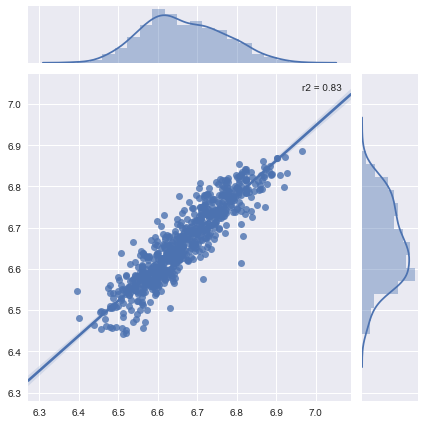

Plot of Actual vs. Predicted Sales Prices (Transformed): Fold 4


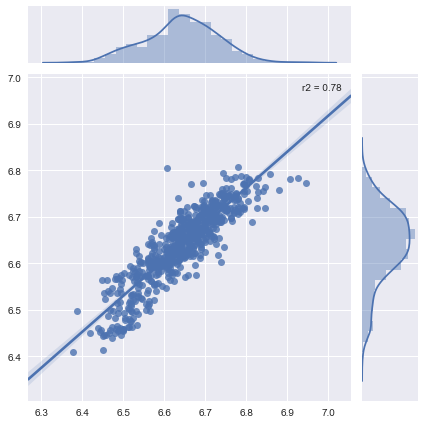

Plot of Actual vs. Predicted Sales Prices (Transformed): Fold 5


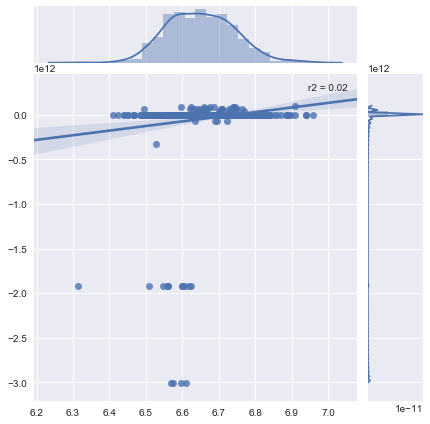

In [44]:
#let's test this model using k-fold cross-validation to determine if we want to use it
from sklearn import cross_validation

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

test_no = 1
kf = cross_validation.KFold(X.shape[0], n_folds=5)
for train, test in kf:
    x_train, x_test = X.values[train], X.values[test]
    y_train, y_test = Y.values[train], Y.values[test]
    #Use regr model defined above
    pred = regr.fit(x_train, y_train).predict(x_test)
    print('Plot of Actual vs. Predicted Sales Prices (Transformed): Fold', test_no)
    sns.jointplot(y_test, pred, kind="reg", stat_func=r2)
    plt.show()
    test_no = test_no + 1

In [36]:
#Now let's focus on the KNN model. Let's start the KNN model based on our df2 set
df2.head()

,Suburb,Type,Bedrooms,Bathrooms,Distance,Latitude,Longitude,Landsize,BuildingArea,Car,Price
2,Abbotsford,h,2.0,1.0,2.5,-37.8079,144.9934,156.0,79.0,0.0,1035000.0
4,Abbotsford,h,3.0,2.0,2.5,-37.8093,144.9944,134.0,150.0,0.0,1465000.0
6,Abbotsford,h,3.0,1.0,2.5,-37.8072,144.9941,120.0,142.0,2.0,1600000.0
11,Abbotsford,h,4.0,2.0,2.5,-37.8024,144.9993,245.0,210.0,0.0,1876000.0
14,Abbotsford,h,2.0,1.0,2.5,-37.8060,144.9954,256.0,107.0,2.0,1636000.0


In [37]:
#KNN can't use categorical variables, and the variables need to be normalized

#For KNN, try transforming the lat & long variables to z-scores (std devs from mean), along w/ bedrooms, bathrooms, landsize & building area
#For KNN, try transforming the lat & long variables to min-max scaling, along w/ bedrooms, bathrooms, landsize & building area

knn_df = df2[['Bedrooms', 'Bathrooms', 'Latitude', 'Longitude', 'Landsize', 'BuildingArea', 'Car']]

from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(knn_df)
df_std = std_scale.transform(knn_df)

minmax_scale = preprocessing.MinMaxScaler().fit(knn_df)
df_minmax = minmax_scale.transform(knn_df)

KNN Plot of Actual vs. Predicted Sales Prices (Z-scores)


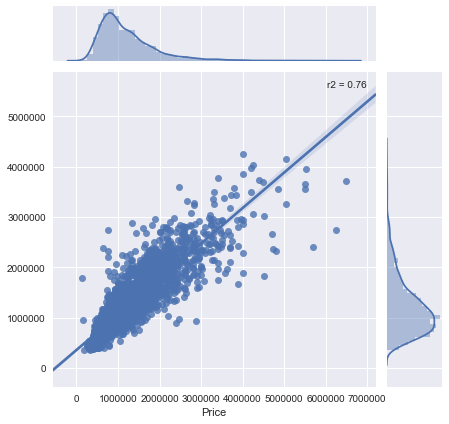

In [38]:
## Your model here.
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=7)

#####IF I CHANGE TO n-neighbors = 1 then r^2 becomes 1.... WHY? #######

X = pd.DataFrame(df_std)
Y = df3['Price']
knn.fit(X, Y)

knn_pred = knn.predict(X).ravel()
knn_actual = Y


print('KNN Plot of Actual vs. Predicted Sales Prices (Z-scores)')
sns.jointplot(knn_actual, knn_pred, kind="reg", stat_func=r2)
#Lplt.show()

KNN Plot of Actual vs. Predicted Sales Prices: Fold 1


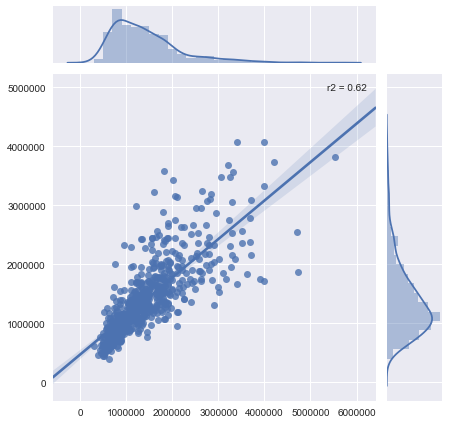

KNN Plot of Actual vs. Predicted Sales Prices: Fold 2


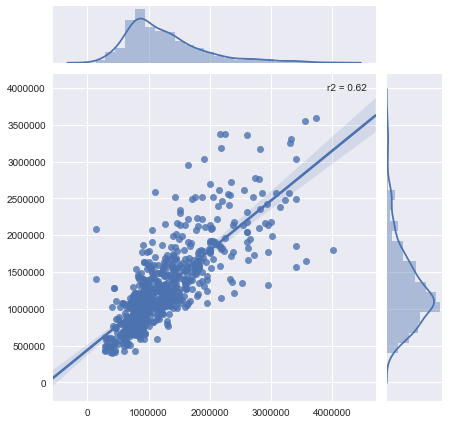

KNN Plot of Actual vs. Predicted Sales Prices: Fold 3


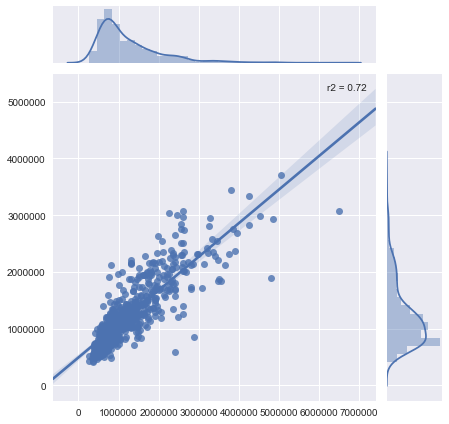

KNN Plot of Actual vs. Predicted Sales Prices: Fold 4


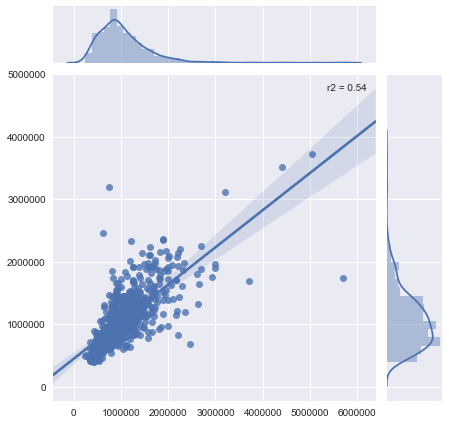

KNN Plot of Actual vs. Predicted Sales Prices: Fold 5


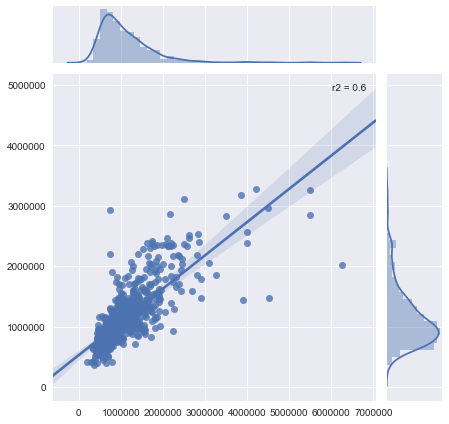

In [39]:
#Lets do some cross-validation of the KNN model

from sklearn import cross_validation


test_no = 1
kf = cross_validation.KFold(X.shape[0], n_folds=5)
for train, test in kf:
    x_train, x_test = X.values[train], X.values[test]
    y_train, y_test = Y.values[train], Y.values[test]
    #Use regr model defined above
    pred = knn.fit(x_train, y_train).predict(x_test)
    print('KNN Plot of Actual vs. Predicted Sales Prices: Fold', test_no)
    sns.jointplot(y_test, pred, kind="reg", stat_func=r2)
    plt.show()
    test_no = test_no + 1

In [40]:
#Other methods we could potentially use to improve KNN:

#Reduce feature set (potentially w/ PCA), play around w/ num neighbors, weighting by distance

In [41]:
#Limitation of KNN - sometimes we can't use categorical variables at all (although you can creatively convert sometimes, 
#like suburb to latitude/longitude coordiates, maybe)

#Difficult to maintain assumption of equal units in the predictor variables for KNN... eg beds/baths/lat/long. Have to standardize

#Shortcomings of regression model: